In [ ]:
!git clone https://github.com/openai/guided-diffusion.git

Cloning into 'guided-diffusion'...
remote: Enumerating objects: 113, done.
remote: Total 113 (delta 0), reused 0 (delta 0), pack-reused 113 (from 1)
Receiving objects: 100% (113/113), 67.86 KiB | 1.01 MiB/s, done.
Resolving deltas: 100% (47/47), done.


In [ ]:
!pip install -q lovely-tensors lovely-numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.2 MB/s eta 0:00:00


In [ ]:
import sys

sys.path.append('/content/guided-diffusion')

import guided_diffusion

In [ ]:
!wget -O checkpoint.pt https://openaipublic.blob.core.windows.net/diffusion/jul-2021/128x128_diffusion.pt

--2024-11-17 09:53:17--  https://openaipublic.blob.core.windows.net/diffusion/jul-2021/128x128_diffusion.pt
Resolving openaipublic.blob.core.windows.net (openaipublic.blob.core.windows.net)... 57.150.97.129
Connecting to openaipublic.blob.core.windows.net (openaipublic.blob.core.windows.net)|57.150.97.129|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1686227960 (1.6G) [application/octet-stream]
Saving to: ‘checkpoint.pt’

checkpoint.pt       100%[===================>]   1.57G  31.7MB/s    in 60s     

2024-11-17 09:54:17 (26.9 MB/s) - ‘checkpoint.pt’ saved [1686227960/1686227960]



In [ ]:
from guided_diffusion.script_util import create_model, create_model_and_diffusion, model_and_diffusion_defaults

defaults = model_and_diffusion_defaults()

args = {
  "attention_resolutions": "32,16,8",
  "class_cond": True,
  "diffusion_steps": 1000,
  "image_size": 128,
  "learn_sigma": True,
  "noise_schedule": "linear",
  "num_channels": 256,
  "num_heads": 4,
  "num_res_blocks": 2,
  "resblock_updown": True,
  "use_fp16": True,
  "use_scale_shift_norm": True
}

defaults.update(args)


model, diffusion = create_model_and_diffusion(
    **defaults
)

def beta_to_step(beta):
    betas = 1.0 - diffusion.alphas_cumprod
    index = (betas < beta).astype(float).sum()

    index = int(index)
    if index == len(betas):
      return index - 1
    low_beta = betas[index]
    high_beta = betas[index + 1]

    part = (beta - low_beta) / (high_beta - low_beta)
    step = index + part
    return step

In [ ]:
import torch

ckpt = torch.load('checkpoint.pt', map_location='cpu')
model.load_state_dict(ckpt)

model = model.cuda()
model.convert_to_fp16()

model = model.eval()

<ipython-input-6-05081a0b42c7>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load('checkpoint.pt', map_location='cpu')


In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import lovely_tensors as lt

def to_image(x):
    img = x[0].cpu().detach()
    img = (img - img.min()) / (img.max() - img.min())
    img = img.permute(1, 2, 0)
    img = img.numpy()
    img = img * 255.
    img = img.astype('uint8')
    return img


def call_model(model, x, beta, y=285):
    t = torch.tensor([beta_to_step(beta)]).cuda()
    c = torch.tensor([y]).cuda()

    res = model.forward(x, t, c).detach()

    return res[:, :3, :, :]


def step_to_beta(step):
    index = int(step // 1)
    shift = step % 1

    betas = 1.0 - diffusion.alphas_cumprod

    if index >= len(betas) - 1:
        return betas[-1]

    a = betas[index]
    b = betas[index + 1]

    return a + (b - a) * shift


def beta_to_step(beta):
    betas = 1.0 - diffusion.alphas_cumprod
    index = (betas <= beta).astype(float).sum() - 1

    index = int(index)

    if index < 0:
      return 0

    if index >= len(betas) - 1:
      return len(betas) - 1

    low_beta = betas[index]
    high_beta = betas[index + 1]

    part = (beta - low_beta) / (high_beta - low_beta)
    step = index + part
    return step

In [ ]:
generator = torch.Generator().manual_seed(42)

sample = torch.randn([1, 3, 128, 128], generator=generator).cuda()

In [ ]:
print(lt.lovely(sample))

tensor[1, 3, 128, 128] n=49152 (0.2Mb) x∈[-4.590, 4.221] μ=0.002 σ=1.007 cuda:0


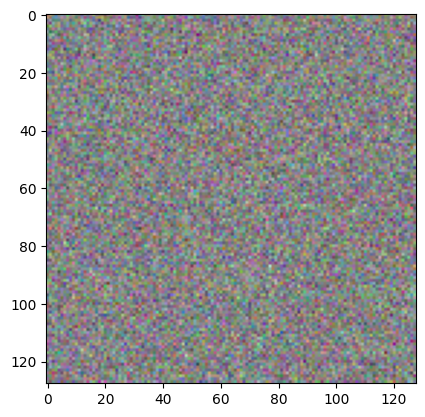

In [ ]:
plt.imshow(to_image(sample))

In [ ]:
res = call_model(model, sample, 0.1)

In [ ]:
print(lt.lovely(res))

tensor[1, 3, 128, 128] n=49152 (0.2Mb) x∈[-6.551, 6.238] μ=-0.008 σ=1.030 cuda:0


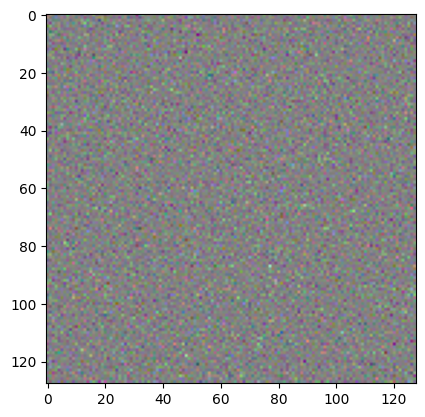

In [ ]:
plt.imshow(to_image(res[:, :3]))

# DDIM

In [ ]:
generator = torch.Generator().manual_seed(0)

res = torch.randn([1, 3, 128, 128], generator=generator).cuda()

betas = np.linspace(0.001, 0.999, 1000)[::-1]

with torch.no_grad():
  for step in tqdm.trange(len(betas) - 1):

        beta_this = betas[step]
        beta_next = betas[step + 1]

        e = call_model(model, res, beta_this)

        x0 = res - e * np.sqrt(beta_this)
        res = x0/np.sqrt(1 - beta_this) * np.sqrt(1 - beta_next) + e * np.sqrt(beta_next)

100%|██████████| 999/999 [01:13<00:00, 13.53it/s]


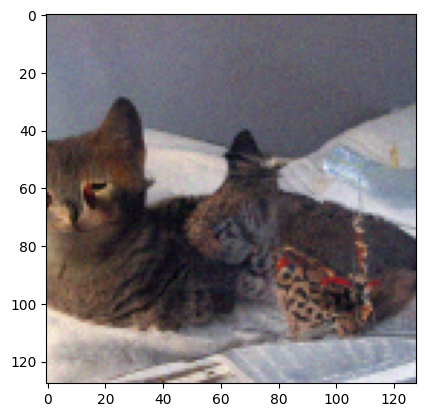

In [ ]:
plt.imshow(to_image(res))

# Euler

In [ ]:
generator = torch.Generator().manual_seed(0)
res = torch.randn([1, 3, 128, 128], generator=generator).cuda()

num_steps = 1000
betas = np.linspace(0.001, 0.999, num_steps)[::-1]

def F(x, beta):
    coeff = 1 / (1 - beta)
    with torch.no_grad():
        e = call_model(model, x, beta)

    return 0.5 * (x - e / beta ** 0.5) * coeff

for beta in betas[:-1]:
    dt = 0.999 / (num_steps - 1)
    res = res + F(res, beta) * dt

tensor[1, 3, 128, 128] n=49152 (0.2Mb) x∈[-0.993, 0.836] μ=-0.237 σ=0.376 cuda:0


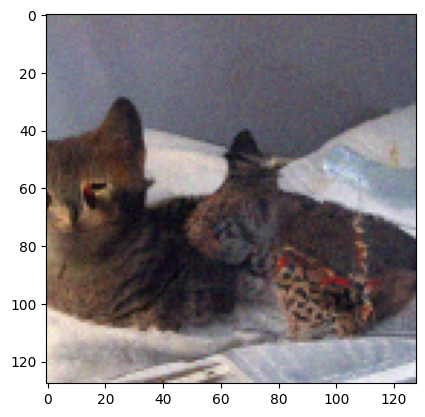

In [ ]:
print(lt.lovely(res))
plt.imshow(to_image(res))

# Heun's Solver

In [ ]:
generator = torch.Generator().manual_seed(0)
res = torch.randn([1, 3, 128, 128], generator=generator).cuda()

num_steps = 1000
betas = np.linspace(0.001, 0.999, num_steps)[::-1]

for beta in betas[:-1]:
    dt = 0.998 / (num_steps - 1)

    k1 = F(res, beta)
    if step != 0:
        k2 = F(res + k1 * dt, beta - dt)
    else:
        k2 = k1

    res = res + (k1 + k2) * dt / 2

tensor[1, 3, 128, 128] n=49152 (0.2Mb) x∈[-0.978, 0.820] μ=-0.218 σ=0.368 cuda:0


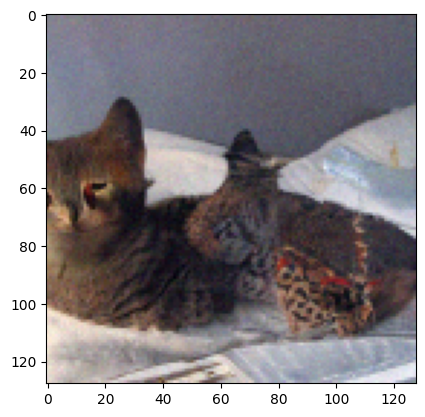

In [ ]:
print(lt.lovely(res))
plt.imshow(to_image(res))